In [1]:
%load_ext autoreload
%autoreload 2

In [70]:
from pathlib import Path
import polars as pl
import fastai.vision.all as fv
import numpy as np
import torch

# Enable TFloat
torch.set_float32_matmul_precision('high')

from torch.utils.data import Dataset
from einops.layers.torch import Rearrange
from einops import rearrange
from torchvision.ops import Permute
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split

from typing import Callable, Optional
from torch import nn, Tensor
from torch.nn import functional as F
from functools import partial

In [3]:
#test_df = pl.read_csv('/mnt/ssd/kaggle/test.csv')
weightings = pd.read_csv('/mnt/ssd/kaggle/sample_submission.csv', nrows=1)
#weightings = weightings.columns[1:]
#train_df = pl.read_csv('/mnt/storage/kaggle/train.csv', n_rows=4_000_000, dtypes=[pl.datatypes.String] + [pl.Float32]*924, n_threads=10)

In [4]:
weights = weightings.iloc[0, 1:].values.astype(np.float32)


In [5]:
(weights == 0).sum()

63

In [9]:
train_df.mean(axis=0)*weights

/tmp/ipykernel_6085/2482930099.py:1: DeprecationWarning: The `axis` parameter for `DataFrame.mean` is deprecated. Use `DataFrame.mean_horizontal()` to perform horizontal aggregation.
  train_df.mean(axis=0)*weights


In [6]:
#train_df.write_parquet('/mnt/ssd/kaggle/train2.parquet')
#test_df.write_parquet('/mnt/ssd/kaggle/test.parquet')
test_df = pl.read_parquet('/mnt/ssd/kaggle/test.parquet')
train_df = pl.read_parquet('/mnt/ssd/kaggle/train2.parquet')

In [7]:
FEAT_COLS = train_df.columns[1:557-60*3]
TARGET_COLS= train_df.columns[557:]

In [8]:
train_df

sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,state_t_10,state_t_11,state_t_12,state_t_13,state_t_14,state_t_15,state_t_16,state_t_17,state_t_18,state_t_19,state_t_20,state_t_21,state_t_22,state_t_23,state_t_24,state_t_25,state_t_26,state_t_27,state_t_28,state_t_29,state_t_30,state_t_31,state_t_32,state_t_33,state_t_34,state_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""train_0""",213.806122,222.244461,229.259872,245.743958,258.337494,265.772461,263.978455,254.879868,243.946152,236.706985,230.934479,226.459625,222.014099,216.912964,210.688507,205.181519,201.649948,199.354248,196.582993,198.087326,200.302673,204.510696,209.294266,214.299316,219.180878,223.644699,227.899261,231.883469,235.859161,239.754486,243.663605,247.494141,251.145752,254.734833,258.118805,261.322876,…,6.3101e-7,3.8035e-7,2.6436e-8,-7.3957e-8,-1.0226e-7,-1.5508e-7,1.8131e-8,1.8428e-7,-1.9102e-8,1.8966e-7,-3.4925e-8,-2.5049e-7,-3.5119e-7,3.1814e-8,-0.000001,-0.000002,-7.6918e-7,-0.000007,-0.000007,-0.000021,-0.000008,0.000024,0.00002,0.000008,0.000003,2.1486e-7,-0.000001,-6.1321e-7,0.000001,0.0,349.564331,0.0,2.9477e-12,0.0,0.0,0.0,0.0
"""train_1""",213.177429,225.851059,229.66362,246.828339,261.026428,269.07843,267.736572,256.89624,244.169418,236.844421,231.586365,227.873489,224.125183,219.864136,214.768661,209.773682,206.593765,205.144608,202.219681,203.165573,203.691772,206.691879,210.018967,213.651749,217.226715,220.732834,224.27124,227.879257,231.523117,235.206558,238.911194,242.569839,246.095627,249.66188,253.170197,256.545227,…,2.3532e-7,-0.000002,4.7710e-7,-4.6249e-7,-4.7910e-7,3.4284e-7,1.5265e-7,-3.6109e-7,4.7664e-7,2.6672e-7,-1.8301e-7,-0.000001,-3.2145e-8,0.000002,-0.000002,-0.000005,-0.000006,-0.000002,-0.000009,-0.000015,-0.000008,0.000017,0.000023,0.000013,0.000004,7.6476e-7,-8.6454e-7,3.5609e-7,9.9849e-7,0.0,335.204071,0.0,3.1384e-9,0.0,0.0,0.0,0.0
"""train_2""",217.105682,220.448105,234.653397,244.422958,254.023819,259.651459,257.709503,251.064514,241.879593,234.48732,228.294373,223.660522,219.108749,214.820511,208.639572,201.056,193.462402,190.267838,188.690125,189.957245,196.482056,203.461777,210.517853,217.264496,223.298203,228.871994,234.369614,239.208267,243.596725,247.68811,251.63942,255.233658,258.531036,261.569672,264.470154,267.068573,…,-0.000002,-6.3580e-7,-0.000001,-5.8939e-7,-6.8356e-7,1.3912e-7,-1.8613e-7,-3.5363e-7,5.9231e-7,-5.4433e-7,-4.1161e-7,-7.6074e-7,-3.6474e-7,5.2729e-7,0.000002,0.000006,0.000013,0.000012,0.000016,0.000005,-0.000005,-0.00002,-0.00004,-0.000035,-0.00002,-0.000013,-0.000004,0.000002,0.000062,0.0,401.709351,0.0,7.4242e-9,0.0,0.0,0.0,0.0
"""train_3""",217.773987,225.611771,234.104095,247.745361,257.411407,263.470947,261.131775,253.303253,242.316818,234.396271,227.955017,223.999863,219.658844,215.244919,210.214691,204.137726,196.509277,191.893677,189.929398,190.806366,196.696884,203.680756,210.684967,217.256989,223.168854,228.660416,233.84549,238.535217,242.747314,246.688904,250.429062,253.907013,257.260437,260.436615,263.363251,266.154816,…,-0.000002,-0.000002,-8.0713e-7,-7.1824e-8,-1.6555e-8,-1.6542e-7,3.0559e-7,1.8800e-8,-1.3640e-7,2.0172e-7,-2.4224e-7,2.5207e-7,0.000001,-7.9637e-8,0.000002,0.000005,0.000003,-0.000002,-0.000003,-0.000001,0.000004,0.000013,-0.000001

In [9]:
NUM_VERT = 60
NUM_VERT_FEAT = 6
NUM_VERT_FEAT_Y = 6

FEAT_COLS = train_df.columns[1:557-60*3]
TARGET_COLS= train_df.columns[557:]


In [11]:
NUM_2D_FEAT = len(FEAT_COLS) - NUM_VERT*NUM_VERT_FEAT
NUM_2D_FEAT_Y = len(TARGET_COLS) - NUM_VERT*NUM_VERT_FEAT_Y

NUM_2D_FEAT, NUM_2D_FEAT_Y

(16, 8)

In [12]:
FEAT_COLS[-NUM_2D_FEAT:], TARGET_COLS[-NUM_2D_FEAT_Y:]

(['state_ps',
  'pbuf_SOLIN',
  'pbuf_LHFLX',
  'pbuf_SHFLX',
  'pbuf_TAUX',
  'pbuf_TAUY',
  'pbuf_COSZRS',
  'cam_in_ALDIF',
  'cam_in_ALDIR',
  'cam_in_ASDIF',
  'cam_in_ASDIR',
  'cam_in_LWUP',
  'cam_in_ICEFRAC',
  'cam_in_LANDFRAC',
  'cam_in_OCNFRAC',
  'cam_in_SNOWHLAND'],
 ['cam_out_NETSW',
  'cam_out_FLWDS',
  'cam_out_PRECSC',
  'cam_out_PRECC',
  'cam_out_SOLS',
  'cam_out_SOLL',
  'cam_out_SOLSD',
  'cam_out_SOLLD'])

In [13]:
x_train = train_df.select(FEAT_COLS).to_numpy()
y_train = train_df.select(TARGET_COLS).to_numpy()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=42)

In [55]:
x_test = test_df.select(FEAT_COLS).to_numpy()

In [14]:
import gc
gc.collect()

16

In [15]:
class Norm():
    def __init__(self, dataset, names, eps=1e-15):
        self.means, self.stds = np.mean(dataset, axis=0), np.std(dataset, axis=0)
        self.eps=eps
        self.df = pd.DataFrame({'col' : names, 'std' : self.stds, 'mean' : self.means})
        
    def __call__(self, data):
        return (data - self.means) / (self.stds + self.eps)
    
    def denorm(self, data):
        return data * (self.stds + self.eps) + self.means 


In [16]:
norm_x = Norm(x_train, FEAT_COLS)
norm_y = Norm(y_train, TARGET_COLS)

In [17]:
class Loader(Dataset):
    def __init__(self, data_dict, norm_dict):
        self.data_dict = data_dict
        self.norm_dict = norm_dict
        
    def __getitem__(self, idx):
        x = self.data_dict['x'][idx]
        y = self.data_dict['y'][idx]
        x = self.norm_dict['x'](x)
        y = self.norm_dict['y'](y)
        return torch.from_numpy(x), torch.from_numpy(y)
    
    def __len__(self,):
        return self.data_dict['x'].shape[0]

In [56]:
train_ds = Loader({'x' : x_train, 'y' : y_train}, {'x' : norm_x, 'y' : norm_y})
val_ds = Loader({'x' : x_val, 'y' : y_val}, {'x' : norm_x, 'y' : norm_y})

In [57]:
len(train_ds), len(val_ds)

(3800000, 200000)

In [58]:
bs = 128
train_loader = fv.DataLoader(train_ds, batch_size=bs, drop_last=True, 
                          shuffle=True, num_workers=1, pin_memory=True)
valid_loader = fv.DataLoader(val_ds, batch_size=bs, drop_last=True,
                            shuffle=False, num_workers=1, pin_memory=True)

In [21]:
x,y = next(iter(train_loader))

In [59]:
batch = next(iter(train_loader))
batch[0].mean(), batch[0].std(), batch[1].mean(), batch[1].std(), batch[0].min(), batch[0].max(), batch[1].min(), batch[1].max()

(tensor(0.0533),
 tensor(0.9269),
 tensor(-0.0008),
 tensor(0.8575),
 tensor(-4.3581),
 tensor(12.2134),
 tensor(-16.5271),
 tensor(22.1823))

In [73]:

class CNBlock1d(nn.Module):
    def __init__(
        self,
        dim,
        layer_scale: float = 1e-4,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        kernel_size = 15
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = partial(nn.LayerNorm, eps=1e-6)

        self.block = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, padding=kernel_size//2, 
                      groups=dim, bias=True, padding_mode='replicate'),
            Permute([0, 2, 1]),
            norm_layer(dim),
            nn.Linear(in_features=dim, out_features=4 * dim, bias=True),
            nn.GELU(),
            nn.Linear(in_features=4 * dim, out_features=dim, bias=True),
            Permute([0, 2, 1]),
        )
        self.layer_scale = nn.Parameter(torch.ones(1, dim, 1) * layer_scale)

    def forward(self, input: Tensor) -> Tensor:
        result = self.layer_scale * self.block(input)
        return result + input
    
class Net(nn.Module):
    def __init__(self, num_in_2d,  num_3d_in, num_2d_out, num_3d_out, num_vert=60, mid_ch=256,
                       num_blocks=12, block = CNBlock1d):
        super().__init__()
        self.num_2d_in = num_in_2d
        self.num_3d_in = num_3d_in
        self.num_2d_out = num_2d_out
        self.num_3d_out = num_3d_out
        self.num_vert = num_vert
        
        self.layer_2d_3d = nn.Sequential(nn.Conv1d(num_in_2d, num_in_2d*num_vert, kernel_size=1, groups=num_in_2d),
                                         Rearrange('b (c z) x -> b c (z x)', c=num_in_2d, z=num_vert, x=1))
        
        self.layer_3d = nn.Sequential(Rearrange('b (c z) -> b c z', c=num_3d_in, z=num_vert),
                                      nn.Conv1d(num_3d_in, mid_ch - num_in_2d, kernel_size=1, groups=num_3d_in))
        # conv_down = partial(nn.Conv3d, kernel_size=[1, 3, 3], padding=(0, 0, 0), padding_mode='reflect')
        # layers = [conv_down(num_2d_3d + num_3d_in, mid_ch//2), nn.GELU(), 
        #           conv_down(mid_ch//2, mid_ch), nn.GELU(),
        #           Rearrange('b c z y x -> b c (z y x)', y=1, x=1)]
        
        self.blocks = nn.Sequential(*[block(mid_ch) for _ in range(num_blocks)])
        
        self.out_3d = nn.Sequential(block(mid_ch), 
                                    nn.Conv1d(mid_ch, num_3d_out, 1), 
                                    Rearrange('b c z -> b (c z)'))
        self.out_2d = nn.Sequential(block(mid_ch), 
                                    nn.Conv1d(mid_ch, num_2d_out, 1))
        
    def forward(self, x):
        split_idx = self.num_3d_in * self.num_vert

        x_3d, x_2d = x[:, :split_idx], x[:, split_idx:]
        x_2d = self.layer_2d_3d(x_2d[..., None])
        x_3d = torch.cat([x_2d, self.layer_3d(x_3d)], dim=1)
        
        x_3d =  self.blocks(x_3d)
        out_3d = self.out_3d(x_3d)
        out_2d = self.out_2d(x_3d).mean(dim=-1)
        return torch.cat([out_3d, out_2d], dim=1)
        
        

In [74]:
net = Net(NUM_2D_FEAT, NUM_VERT_FEAT, NUM_2D_FEAT_Y, NUM_VERT_FEAT_Y)
net = torch.compile(net)

In [75]:

dls = fv.DataLoaders(train_loader, valid_loader).to('cuda')

In [76]:
pred_mask = weights != 0
pred_mask = torch.tensor(pred_mask, device='cuda')
pred_mask.sum()

tensor(305, device='cuda:0')

In [77]:
def l1_loss(tar, pred):
    return torch.abs(tar[:, pred_mask] - pred[:, pred_mask]).mean()

In [78]:
def mse(tar, pred):
    return F.mse_loss(tar[:, pred_mask], pred[:, pred_mask])

def r_squared(tar, pred):
    tar = norm_y.denorm(tar.cpu().numpy())
    pred = norm_y.denorm(pred.detach().cpu().numpy())
    pred = pred*weights[None, :]
    tar = tar*weights[None, :]
    return 1 - (np.sum((tar - pred)**2) / np.sum((tar - tar.mean())**2))
    

In [79]:
learn = fv.Learner(dls, net, loss_func=l1_loss, metrics=[fv.mae, fv.mse, r_squared], wd=0.001, opt_func=fv.ranger)

SuggestedLRs(valley=0.0010000000474974513)

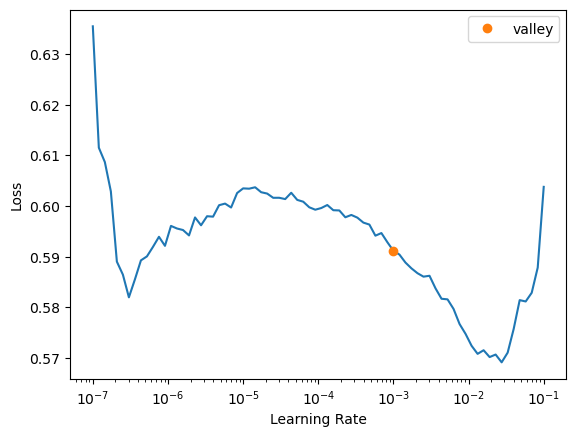

In [80]:
learn.lr_find()

In [82]:
learn.fit_flat_cos(6, 7e-3)

epoch,train_loss,valid_loss,mae,mse,r_squared,time


In [81]:
learn.fit_flat_cos(5, 3e-3)

epoch,train_loss,valid_loss,mae,mse,r_squared,time


KeyboardInterrupt: 